<h3> Importing Libraries </h3>

In [145]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
import matplotlib.pyplot as plt

<h3> Loading +/- Data </h3>

In [146]:
# Load positive and negative data sets as dataframe
positive_data = pd.read_csv('../deep_annotator_data/positive_sample.txt', header=None, nrows=1000)
positive_data.columns = ["Gene"]
negative_data = pd.read_csv('../deep_annotator_data/negative_sample.txt', header=None, nrows=1000)
negative_data.columns = ["Gene"]

<h3> Hyper Parameters </h3>

In [147]:
batch_size = 100
embedding_size = 5
fc_layer_size = (len(positive_data.Gene[0])-(window-1))*embedding_size
hidden_layer_size = 100
num_layers = 2
epochs = 1000
lr = 0.2
window = 1

<h3> Generate word IDs <h3>

In [148]:
strings = set()
def allLexicographicRecur (string, data, last, index): 
    length = len(string)
    for i in range(length): 
        data[index] = string[i] 
        if index==last:
            res = ''.join(data)
            strings.add(res)
        else: 
            allLexicographicRecur(string, data, last, index+1) 
def allLexicographic(string, n): 
    length = len(string)
    data = [""] * (length+1)
    string = sorted(string) 
    allLexicographicRecur(string, data, window-1, 0)
string = "01234"
allLexicographic(string, window)
strings = sorted(strings)
vocabulary = {}
for val, i in enumerate(strings):
    vocabulary[i] = val
# print(word_ids)

<h3> Generate Word Embeddings </h3>

In [149]:
embeds = nn.Embedding(len(vocabulary), 5)
embeddings = {}
def generate_embeddings():
    for word in vocabulary:
        embeddings[word] = embeds(torch.tensor(vocabulary[word], dtype=torch.long))

generate_embeddings()

In [150]:
def generate_samples(data_sample):
    list_of_tensors = []
    for data in data_sample.itertuples():
        for i in range(len(data.Gene) - window + 1):
            if i == 0:
                first_tensor = embeddings[data.Gene[i:i+window]]
            else:
                first_tensor = torch.cat((first_tensor, embeddings[data.Gene[i:i+window]]), 0)
        list_of_tensors.append(first_tensor)
    trainpositives = torch.stack(list_of_tensors)
    return trainpositives

positives = generate_samples(positive_data)
negatives = generate_samples(negative_data)
data_ = torch.cat([positives, negatives], dim=0)

negative_labels = torch.zeros(negatives.shape[0], 1)
positive_labels = torch.ones(positives.shape[0], 1)
labels_ = torch.cat([positive_labels, negative_labels], dim=0)

<h3> Neural Network Layer Implementation </h3>

In [151]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lstm = nn.LSTM(fc_layer_size, fc_layer_size, num_layers)
        self.fc1 = nn.Linear(fc_layer_size, hidden_layer_size)
        self.relu1 = nn.Sigmoid()
        # self.fc2 = nn.Linear(fc_layer_size, hidden_layer_size)
        # self.prelu = nn.Sigmoid()
        self.out = nn.Linear(hidden_layer_size, 1)
        self.out_act = nn.Sigmoid()

    def forward(self, x):
        h = autograd.Variable(torch.randn(num_layers, batch_size, fc_layer_size))
        c = autograd.Variable(torch.randn(num_layers, batch_size, fc_layer_size))
        out_lstm, hn = self.lstm(x, (h, c))
        a1 = self.fc1(out_lstm)
        h1 = self.relu1(a1)
        # a2 = self.fc2(h1)
        # h2 = self.prelu(a2)
        a3 = self.out(h1)
        y = self.out_act(a3)
        return y
net = Net()

<h4> Optimizer step and loss calculation </h4>

In [152]:
opt = optim.SGD(net.parameters(), lr, momentum=0.0)
criterion = nn.BCELoss()

<h4> Train method </h4>

In [153]:
def train_epoch(model, opt, criterion, batch_size):
    model.train()
    losses = []
    for beg_i in range(0, data_.size(0), batch_size):
        data_batch = data_[beg_i:beg_i + batch_size, :]
        labels_batch = labels_[beg_i:beg_i + batch_size, :]
        data_batch = autograd.Variable(data_batch)
        labels_batch = autograd.Variable(labels_batch)

        opt.zero_grad()
        
        # Extend the side of the data_batch to adhere to LSTM layer implementation
        data_batch.unsqueeze_(0)
        data_batch = data_batch.expand(1, batch_size, fc_layer_size)
        labels_hat = net(data_batch)
        
        # Compute the binary Cross Entropy Loss
        loss = criterion(labels_hat, labels_batch)

        loss.backward()

        opt.step()        
        losses.append(loss.data.numpy())
    loss = sum(losses)/len(losses)
    return loss

In [154]:
def train():
    losses = []
    for e in range(epochs):
        loss = train_epoch(net, opt, criterion, batch_size)
        losses.append(loss)
        if e % 200 == 0:
            print('Average Loss at epoch,',e,':',loss)
    torch.save(net.state_dict(), 'fc_with_lstm.pt')
    plt.plot(losses)
# train()

<h3> Test Data Prediction </h3>

<h4> Load the Model and test data </h4>

In [155]:
#load model
model = Net()
model.load_state_dict(torch.load('fc_with_lstm.pt'))
model.eval()

# load data
positive_test_data = pd.read_fwf('positive_sample_test.txt', header = None)
positive_test_data.columns = ["Gene"]
negative_test_data = pd.read_fwf('negative_sample_test.txt', header = None)
negative_test_data.columns = ["Gene"]

<h4> Test and Label Embeddings </h4>

In [156]:
positives_test_data = generate_samples(positive_test_data)
negatives_test_data = generate_samples(negative_test_data)

data_test = torch.cat([positives_test_data, negatives_test_data], dim=0)

negative_labels_test = torch.zeros(negatives_test_data.shape[0], 1)
positive_labels_test = torch.ones(positives_test_data.shape[0], 1)
labels_test = torch.cat([positive_labels_test, negative_labels_test], dim=0)

<h4> Generate output labels for test predictions </h4>

In [157]:
def test_prediction_model(data_test, labels_predicted):
    for beg_i in range(0, len(data_test), batch_size):
        data_test_ = data_test[beg_i:beg_i + batch_size, :]
        data_test_.unsqueeze_(0)
        data_testing = data_test_.expand(1, batch_size, fc_layer_size)
        labels_hat = net(data_testing)
        labels_hat = labels_hat.view(1,batch_size)
        labels_hat = torch.transpose(labels_hat, 0, 1)
#         softmax = nn.Softmax(0)
#         labels_hat = softmax(labels_hat)
        for temp in range(labels_hat.shape[0]):
            labels_predicted.append(labels_hat[temp])
        #labels_predicted += labels_hat.numpy()

<h4> Accuracy for Test predictions </h4>

In [158]:
def test_prediction_accuracy(labels):
    correct, wrong = 0, 0
    labels_hat = labels
    for i in range(len(labels_hat)//2 + 1):
        if labels_hat[i] > 0.5:
            correct += 1
        else:
            wrong += 1
    for i in range(101, len(labels_hat)):
        if labels_hat[i] > 0.5:
            wrong += 1
        else:
            correct += 1
    return (correct,wrong)

In [162]:
# labels = []
# test_prediction_model(data_test, labels)
# results = test_prediction_accuracy(labels)
# print("Correct Predictions:", results[0])
# print("Wrong Predictions:", results[1])

Average Loss at epoch, 0 : 0.3496661692857742
Average Loss at epoch, 200 : 0.003306878772127675
Correct Predictions: 176
Wrong Predictions: 24


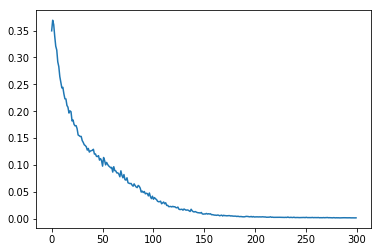

In [163]:
batch_size = 100
embedding_size = 5
fc_layer_size = (len(positive_data.Gene[0])-(window-1))*embedding_size
hidden_layer_size = 100
num_layers = 2
epochs = 300
lr = 0.2
train()
labels = []
test_prediction_model(data_test, labels)
results = test_prediction_accuracy(labels)
print("Correct Predictions:", results[0])
print("Wrong Predictions:", results[1])

In [176]:
batch_size = 100
embedding_size = 5
fc_layer_size = (len(positive_data.Gene[0])-(window-1))*embedding_size
hidden_layer_size = 100
num_layers = 2
epochs = 300
lr = 0.3
train()
labels = []
test_prediction_model(data_test, labels)
results = test_prediction_accuracy(labels)
print("Correct Predictions:", results[0])
print("Wrong Predictions:", results[1])

In [ ]:
batch_size = 100
embedding_size = 5
fc_layer_size = (len(positive_data.Gene[0])-(window-1))*embedding_size
hidden_layer_size = 100
num_layers = 2
epochs = 300
lr = 0.4
train()
labels = []
test_prediction_model(data_test, labels)
results = test_prediction_accuracy(labels)
print("Correct Predictions:", results[0])
print("Wrong Predictions:", results[1])

In [166]:
# batch_size = 100
# embedding_size = 5
# fc_layer_size = (len(positive_data.Gene[0])-(window-1))*embedding_size
# hidden_layer_size = 100
# num_layers = 2
# epochs = 1000
# lr = 0.3
# window = 1
# train()
# labels = []
# test_prediction_model(data_test, labels)
# results = test_prediction_accuracy(labels)
# print("Correct Predictions:", results[0])
# print("Wrong Predictions:", results[1])

In [167]:
# batch_size = 100
# embedding_size = 5
# fc_layer_size = (len(positive_data.Gene[0])-(window-1))*embedding_size
# hidden_layer_size = 100
# num_layers = 2
# epochs = 1000
# lr = 0.3
# window = 3
# train()
# labels = []
# test_prediction_model(data_test, labels)
# results = test_prediction_accuracy(labels)
# print("Correct Predictions:", results[0])
# print("Wrong Predictions:", results[1])

In [168]:
# batch_size = 100
# embedding_size = 5
# fc_layer_size = (len(positive_data.Gene[0])-(window-1))*embedding_size
# hidden_layer_size = 100
# num_layers = 2
# epochs = 1000
# lr = 0.3
# window = 6
# train()
# labels = []
# test_prediction_model(data_test, labels)
# results = test_prediction_accuracy(labels)
# print("Correct Predictions:", results[0])
# print("Wrong Predictions:", results[1])

In [175]:
batch_size = 100
embedding_size = 5
fc_layer_size = (len(positive_data.Gene[0])-(window-1))*embedding_size
hidden_layer_size = 100
num_layers = 2
epochs = 500
lr = 0.2
train()
labels = []
test_prediction_model(data_test, labels)
results = test_prediction_accuracy(labels)
print("Correct Predictions:", results[0])
print("Wrong Predictions:", results[1])

Average Loss at epoch, 0 : 0.00017780718109179362
Correct Predictions: 179
Wrong Predictions: 21


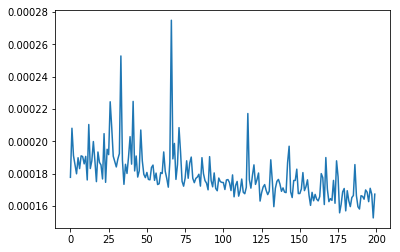

In [170]:
batch_size = 100
embedding_size = 5
fc_layer_size = (len(positive_data.Gene[0])-(window-1))*embedding_size
hidden_layer_size = 100
num_layers = 2
epochs = 200
lr = 0.3
train()
labels = []
test_prediction_model(data_test, labels)
results = test_prediction_accuracy(labels)
print("Correct Predictions:", results[0])
print("Wrong Predictions:", results[1])

Average Loss at epoch, 0 : 0.0001653423283300981
Average Loss at epoch, 200 : 0.00013989556727551645
Average Loss at epoch, 400 : 0.0001364701968668669
Average Loss at epoch, 600 : 0.00011633470505501009
Correct Predictions: 177
Wrong Predictions: 23


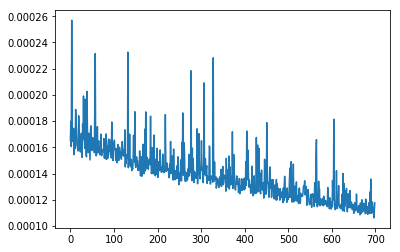

In [171]:
batch_size = 100
embedding_size = 5
fc_layer_size = (len(positive_data.Gene[0])-(window-1))*embedding_size
hidden_layer_size = 100
num_layers = 2
epochs = 700
lr = 0.3
train()
labels = []
test_prediction_model(data_test, labels)
results = test_prediction_accuracy(labels)
print("Correct Predictions:", results[0])
print("Wrong Predictions:", results[1])